In [23]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.optimize as so

# Class for our camera model
class Camera(object):
    def __init__(self):
        self.p = None                   # Pose
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # Sensor
        
    def projective_transform(self,x):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        """
        focal = self.f
        sensor = self.c
        
        #General Coordinates
        gcx = x[0]/x[2]
        gcy = x[1]/x[2]
        
        #Pixel Locations
        pu = gcx*focal + sensor[0]/2.
        pv = gcy*focal + sensor[1]/2.
        
        return np.array([pu,pv])
      
    
    def rotational_transform(self,X,pts):
        """  
        This function performs the translation and rotation from world coordinates into generalized camera coordinates.
        """
        
        cam_x = X[0]
        cam_y = X[1]
        cam_z = X[2]
        roll = X[3]
        pitch = X[4]
        yaw = X[5]
        
        r_axis = np.array([[1, 0, 0], [0, 0,-1], [0, 1, 0]])
        r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], [0, 1, 0], [np.sin(roll), 0, np.cos(roll)]])
        r_pitch = np.array([[1, 0, 0], [0, np.cos(pitch), np.sin(pitch)], [0, -1*np.sin(pitch), np.cos(pitch)]])
        r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], [np.sin(yaw), np.cos(yaw), 0, 0], [0, 0, 1, 0]])

        T = np.array([[1, 0, 0, -cam_x],[0, 1, 0, -cam_y], [0, 0, 1, -cam_z], [0, 0, 0, 1]])
        
        C = r_axis @ r_roll @ r_pitch @ r_yaw @ T

        return C @ pts
    
    def estimate_pose(self,opt_pose):
        self.p = opt_pose
        pass
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """

In [24]:
# Initialize the camera and it's attributes from .exif file
myCam = Camera()

#myCam.f = (28/36)*3024 # Focal length
myCam.f = (28/36)*4032 # Focal length
myCam.c = np.array([4032.,3024.]) # Sensor size

# List to hold the gcp info
gcps = []

# Read in gcp's from file
f = open('image_coordinates.txt', 'r')
for line in f:
    # Remove newline characters
    line = line.replace("\n", "")
    
    # Delimit by comma
    line = line.split(',')
    
    # Convert string array to floats
    for x in range(0,len(line)-1):
        line[x] = float(line[x])
    
    # Add the single gcp
    gcps.append(line)

# Model for our transformation
def f(X_gcp, p):
    transformed = []
    for gcp in X_gcp:
    # Perform rotational transform on X_gcp
        rotated = myCam.rotational_transform(p, gcp)
    # Project the rotated coordinates to pixel coordinates
        projected = myCam.projective_transform(rotated)
        transformed.append(projected)
    
    return transformed # Returns the transformed camera coordinates

# Residual function to calculate the difference in X_gcp and u_gcp
def residual(p0, X_gcp, u_gcp):
    #print(f(X_gcp, p0) - u_gcp)
    all_res = np.array(f(X_gcp, p0)) - np.array(u_gcp)
    all_res = all_res.ravel()
    #print(all_res)
    return all_res # Return the difference in observed and projected coordinates

def ave_opt(opts):
        tot = 0
        for x in range(0,len(opts)):
            tot = tot + opts[x]
        
        return tot / float(len(opts))

# Now we begin to estimate an optimal pose for our model

p_opts = [] # List to hold the local optimum
u_gcps = []
# Finds a local optimum for every GCP
for gcp in gcps:
    # pts = [easting, northing, elevation]
    pts = gcp[2:5]
    # pts = [easting, northing, elevation, 1]
    pts.append(1)
    
    # Observed pixel coordinates
    u_gcp = gcp[0:2]
    p_opts.append(pts)
    u_gcps.append(u_gcp)
    #print("Optimal", p_opt)
    #p_opts.append(p_opt) # Add the local optimum

# Initial guess at the pose
# Find good initial guess
ave_easting = 0
ave_northing = 0
ave_elevation = 0
index = 0
for gcp in gcps:
    ave_easting+=gcp[2]
    ave_northing+=gcp[3]
    ave_elevation+=gcp[4]
ave_easting = ave_easting / len(gcps)
ave_northing = ave_northing / len(gcps)
ave_elevation = ave_elevation / len(gcps)

p0 = np.array([ave_easting, ave_northing, ave_elevation ,90,45,45])
#print("P0", p0)
    
# Find a locally optimal p
p_opt = so.least_squares(residual, p0, method='lm', args=(p_opts,u_gcps))['x']

# Give camera model optimal pose
myCam.p = p_opt

#print(p_opt)
final_coords = [] # Holds the coordinates projected with our optimal camera model

index = 0
#final_opt = ave_opt(p_opts)

pts = []
pt = []
for gcp in gcps:
    pt = gcp[2:5]
    pt.append(1)
    pts.append(pt)


final_coords = f(pts, myCam.p)




Optimal Pose:  [3.22967717e+05 4.30648876e+06 1.25058664e+01 8.80759010e+01
 4.40193405e+01 4.55108456e+01] 

Easting:  322967.7170054466
Northing:  4306488.76338895
Elevation:  12.505866387569295
Roll:  88.07590102399021
Pitch:  44.01934049972259
Yaw:  45.51084561303011


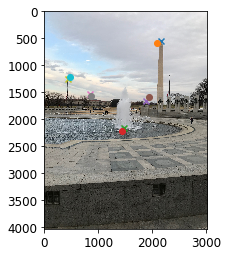

In [25]:
# Plot the GCP's using optimally estimated pose.
plt.rcParams.update({'font.size': 12})
for x in range(0,len(final_coords)):
    plt.scatter(u_gcps[x][0], u_gcps[x][1], marker="x")
    #plt.text(final_coords[x][0], final_coords[x][1], "gcp" + str((x)))
    plt.scatter(final_coords[x][0], final_coords[x][1])
im = plt.imread('national_mall.jpg')
implot = plt.imshow(im)
print("Optimal Pose: ", myCam.p, "\n")
print("Easting: ", myCam.p[0])
print("Northing: ", myCam.p[1])
print("Elevation: ", myCam.p[2])
print("Roll: ", myCam.p[3])
print("Pitch: ", myCam.p[4])
print("Yaw: ", myCam.p[5])